# Model Training

In [2]:
import pandas as pd
import json

# Paths
TRAIN_PROCESSED_PATH = "/kaggle/input/process-data/train_processed.csv"
TEST_PROCESSED_PATH  = "/kaggle/input/process-data/test_processed.csv"
FEATURES_PATH        = "/kaggle/input/process-data/tabular_features.json"

# Load data
train_df = pd.read_csv(TRAIN_PROCESSED_PATH)
test_df  = pd.read_csv(TEST_PROCESSED_PATH)

# Load tabular feature list
with open(FEATURES_PATH, "r") as f:
    TABULAR_FEATURES = json.load(f)

print(train_df.shape, test_df.shape)
print(TABULAR_FEATURES)

(16209, 23) (5404, 22)
['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'lat', 'long', 'house_age', 'is_renovated', 'sale_month_sin', 'sale_month_cos']


In [71]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [72]:
idx = np.arange(len(train_df))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

In [73]:
# Store id separately
train_ids = train_df["id"].copy()
test_ids = test_df["id"].copy()

In [74]:
DATASET_NAME = "house-prediction"
BASE_DIR = f"/kaggle/input/{DATASET_NAME}/RealEstate_Multimodal"

TRAIN_IMG_DIR = f"{BASE_DIR}/images/train"
TEST_IMG_DIR  = f"{BASE_DIR}/images/test"

# Image Only CNN

In [75]:
class ImageOnlyDataset(Dataset):
    def __init__(self, df, ids, img_dir, targets=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.ids = ids.reset_index(drop=True)
        self.img_dir = img_dir
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.ids.iloc[idx]}.png"
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        if self.targets is not None:
            return img, self.targets[idx]
        else:
            return img

In [76]:
class ImageOnlyRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        resnet = models.resnet18(weights=None)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        self.regressor = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        feat = self.cnn(x).view(x.size(0), -1)
        return self.regressor(feat).squeeze(1)

In [77]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],   
        std=[0.229, 0.224, 0.225]    
    )
])

In [78]:
y_log = torch.tensor(
    np.log1p(train_df["price"].values),
    dtype=torch.float32
)

train_img_dataset = ImageOnlyDataset(
    train_df.iloc[train_idx],
    train_ids.iloc[train_idx],
    TRAIN_IMG_DIR,
    targets=y_log[train_idx],
    transform=image_transform
)

val_img_dataset = ImageOnlyDataset(
    train_df.iloc[val_idx],
    train_ids.iloc[val_idx],
    TRAIN_IMG_DIR,
    targets=y_log[val_idx],
    transform=image_transform
)

train_loader = DataLoader(train_img_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_img_dataset, batch_size=32, shuffle=False)

In [79]:
def train_epoch_image(model, loader, optimizer, criterion):
    model.train()
    total = 0

    for img, y in loader:
        img, y = img.to(device), y.to(device)

        optimizer.zero_grad()
        pred = model(img)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total += loss.item() * len(y)

    return total / len(loader.dataset)


def eval_image(model, loader):
    model.eval()
    preds, ys = [], []

    with torch.no_grad():
        for img, y in loader:
            img = img.to(device)
            pred = model(img)

            preds.append(pred.cpu().numpy())
            ys.append(y.numpy())

    preds = np.concatenate(preds)
    ys = np.concatenate(ys)

    rmse = np.sqrt(mean_squared_error(ys, preds))
    r2 = r2_score(ys, preds)

    return rmse, r2

In [80]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [81]:
model = ImageOnlyRegressor().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

EPOCHS = 10

for epoch in range(EPOCHS):
    train_loss = train_epoch_image(model, train_loader, optimizer, criterion)
    rmse, r2 = eval_image(model, val_loader)

    print(
        f"Epoch {epoch+1:02d} | "
        f"Train log-MSE {train_loss:.4f} | "
        f"Val RMSE {rmse:.4f} | "
        f"R² {r2:.4f}"
    )

Epoch 01 | Train log-MSE 8.6369 | Val RMSE 0.5404 | R² -0.0581
Epoch 02 | Train log-MSE 0.2362 | Val RMSE 0.4548 | R² 0.2503
Epoch 03 | Train log-MSE 0.1966 | Val RMSE 0.5775 | R² -0.2087
Epoch 04 | Train log-MSE 0.1760 | Val RMSE 0.4315 | R² 0.3253
Epoch 05 | Train log-MSE 0.1530 | Val RMSE 0.4737 | R² 0.1868
Epoch 06 | Train log-MSE 0.1179 | Val RMSE 0.5273 | R² -0.0077
Epoch 07 | Train log-MSE 0.0873 | Val RMSE 0.4608 | R² 0.2306
Epoch 08 | Train log-MSE 0.0712 | Val RMSE 0.5190 | R² 0.0238
Epoch 09 | Train log-MSE 0.0588 | Val RMSE 0.4374 | R² 0.3066
Epoch 10 | Train log-MSE 0.0477 | Val RMSE 0.5830 | R² -0.2317


# Multimodal Residual

In [15]:
y = np.log1p(train_df["price"].values)

In [16]:
scaler = StandardScaler()
X_tab = scaler.fit_transform(train_df[TABULAR_FEATURES])

X_tab_tensor = torch.tensor(X_tab, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

image_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])

In [17]:
from sklearn.model_selection import train_test_split

idx = np.arange(len(train_df))
train_idx, val_idx = train_test_split(idx, test_size=0.2, random_state=42)

In [18]:
class RealEstateDataset(Dataset):
    def __init__(self, df, ids, img_dir, tab_tensor, targets=None, transform=None):
        self.df = df.reset_index(drop=True)
        self.ids = ids.reset_index(drop=True)
        self.img_dir = img_dir
        self.tab = tab_tensor
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = f"{self.img_dir}/{self.ids.iloc[idx]}.png"
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        tab = self.tab[idx]

        if self.targets is not None:
            return img, tab, self.targets[idx]
        else:
            return img, tab

In [19]:
train_loader = DataLoader(
    RealEstateDataset(
        train_df.iloc[train_idx],
        train_ids.iloc[train_idx],
        TRAIN_IMG_DIR,
        X_tab_tensor[train_idx],
        y_tensor[train_idx],
        image_transform
    ),
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    RealEstateDataset(
        train_df.iloc[val_idx],
        train_ids.iloc[val_idx],
        TRAIN_IMG_DIR,
        X_tab_tensor[val_idx],
        y_tensor[val_idx],
        image_transform
    ),
    batch_size=32,
    shuffle=False,
    num_workers=0
)

In [20]:
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

class MultimodalResidualModel(nn.Module):
    def __init__(self, tab_dim):
        super().__init__()

        resnet = resnet18(weights=None)
        self.cnn = nn.Sequential(*list(resnet.children())[:-1])

        for p in self.cnn.parameters():
            p.requires_grad = False

        self.image_head = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

        self.tabular_net = nn.Sequential(
            nn.Linear(tab_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, img, tab):
        img_feat = self.cnn(img).view(img.size(0), -1)
        img_res  = self.image_head(img_feat).squeeze(1)

        base = self.tabular_net(tab).squeeze(1)

        return base + img_res

In [21]:
cnn_model = MultimodalResidualModel(X_tab_tensor.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)

In [22]:
def train_epoch(loader):
    cnn_model.train()
    total = 0
    for img, tab, y in loader:
        img, tab, y = img.to(device), tab.to(device), y.to(device)

        optimizer.zero_grad()
        pred = cnn_model(img, tab)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        total += loss.item() * len(y)
    return total / len(loader.dataset)

def eval_epoch(loader):
    cnn_model.eval()
    total = 0
    with torch.no_grad():
        for img, tab, y in loader:
            img, tab, y = img.to(device), tab.to(device), y.to(device)
            pred = cnn_model(img, tab)
            total += criterion(pred, y).item() * len(y)
    return total / len(loader.dataset)

In [23]:
for epoch in range(9):
    print(f"Epoch {epoch+1}")
    tr = train_epoch(train_loader)
    va = eval_epoch(val_loader)
    print(f"Epoch {epoch+1} | Train log-MSE {tr:.4f} | Val log-MSE {va:.4f}")

Epoch 1
Epoch 1 | Train log-MSE 4.1540 | Val log-MSE 0.2024
Epoch 2
Epoch 2 | Train log-MSE 0.1280 | Val log-MSE 0.1050
Epoch 3
Epoch 3 | Train log-MSE 0.0933 | Val log-MSE 0.0879
Epoch 4
Epoch 4 | Train log-MSE 0.0826 | Val log-MSE 0.0727
Epoch 5
Epoch 5 | Train log-MSE 0.0759 | Val log-MSE 0.0678
Epoch 6
Epoch 6 | Train log-MSE 0.0716 | Val log-MSE 0.0651
Epoch 7
Epoch 7 | Train log-MSE 0.0692 | Val log-MSE 0.0730
Epoch 8
Epoch 8 | Train log-MSE 0.0650 | Val log-MSE 0.0661
Epoch 9
Epoch 9 | Train log-MSE 0.0622 | Val log-MSE 0.0791


In [24]:
from sklearn.metrics import r2_score
import numpy as np

cnn_model.eval()

preds = []
targets = []

with torch.no_grad():
    for img, tab, y in val_loader:
        img = img.to(device)
        tab = tab.to(device)

        p = cnn_model(img, tab)

        preds.append(p.cpu().numpy())
        targets.append(y.cpu().numpy())

preds = np.concatenate(preds)
targets = np.concatenate(targets)

r2 = r2_score(targets, preds)
print("R² (log-space):", r2)

R² (log-space): 0.7135072350502014


# XGBoost over tabular data

In [25]:
from sklearn.model_selection import train_test_split
X = train_df[TABULAR_FEATURES].values
y = np.log1p(train_df["price"].values)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

In [27]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=500,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

In [28]:
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=-1, num_parallel_tree=None, ...)

In [29]:
val_preds = xgb_model.predict(X_val)

rmse_log = np.sqrt(mean_squared_error(y_val, val_preds))
r2_log = r2_score(y_val, val_preds)

print("XGBoost RMSE (log):", rmse_log)
print("XGBoost R² (log):", r2_log)

XGBoost RMSE (log): 0.16324739075544945
XGBoost R² (log): 0.903426873986678


# Classical fusion via PCA 

In [30]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

resnet = models.resnet18(weights=None)
cnn = nn.Sequential(*list(resnet.children())[:-1]).to(device)
cnn.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [31]:
import numpy as np
from torchvision import transforms
from PIL import Image
import os

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

def extract_image_embeddings(ids, img_dir):
    embeddings = []

    with torch.no_grad():
        for pid in ids:
            img_path = f"{img_dir}/{pid}.png"
            img = Image.open(img_path).convert("RGB")
            img = image_transform(img).unsqueeze(0).to(device)

            feat = cnn(img).view(-1)   # (512,)
            embeddings.append(feat.cpu().numpy())

    return np.array(embeddings)

In [32]:
X_img = extract_image_embeddings(train_ids, TRAIN_IMG_DIR)
print(X_img.shape)   

(16209, 512)


In [33]:
from sklearn.preprocessing import StandardScaler
scaler_img = StandardScaler()
X_img_scaled = scaler_img.fit_transform(X_img)

In [34]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50, random_state=42)

X_img_pca = pca.fit_transform(X_img_scaled)

print("Total explained variance:", pca.explained_variance_ratio_.sum())

Total explained variance: 0.7609159


In [35]:
scaler_tab = StandardScaler()

X_tab = train_df[TABULAR_FEATURES].values
X_tab_scaled = scaler_tab.fit_transform(X_tab)

In [36]:
import numpy as np

X_fusion = np.hstack([X_tab_scaled, X_img_pca])
print("Fusion shape:", X_fusion.shape)

Fusion shape: (16209, 67)


In [37]:
X_train = X_fusion[train_idx]
X_val   = X_fusion[val_idx]

y_train = y[train_idx]
y_val   = y[val_idx]

In [38]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_model(model, X_train, y_train, X_val, y_val):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    r2 = r2_score(y_val, preds)
    return rmse, r2

In [39]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

In [40]:
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    "Random Forest": RandomForestRegressor(
        n_estimators=200,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    ),
    "Gradient Boosting": GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=4,
        random_state=42
    ),
    "XGBoost": XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

In [41]:
import pandas as pd

results = []

for name, model in models.items():
    rmse, r2 = evaluate_model(model, X_train, y_train, X_val, y_val)
    results.append({
        "Model": name,
        "RMSE (log)": rmse,
        "R² (log)": r2
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="RMSE (log)")

,Model,RMSE (log),R² (log)
4,XGBoost,0.168876,0.896653
3,Gradient Boosting,0.172686,0.891937
2,Random Forest,0.189606,0.869722
1,Lasso,0.240968,0.789582
0,Ridge,0.241033,0.789469


# GradCAM

In [47]:
import cv2
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):

        def forward_hook(module, input, output):
            self.activations = output
            output.retain_grad()   

        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, img, tab):
        self.model.zero_grad()

        img.requires_grad_(True)   

        output = self.model(img, tab)

        # Backprop from scalar output
        output.backward()

        if self.gradients is None or self.activations is None:
            raise RuntimeError("Grad-CAM failed: gradients or activations not captured")

        grads = self.gradients
        acts = self.activations

        weights = grads.mean(dim=(2, 3), keepdim=True)
        cam = (weights * acts).sum(dim=1)
        cam = torch.relu(cam)

        cam = cam[0].detach().cpu().numpy()
        cam = cv2.resize(cam, (224, 224))
        cam = (cam - cam.min()) / (cam.max() + 1e-8)

        return cam

In [48]:
target_layer = cnn_model.cnn[-2]   
gradcam = GradCAM(cnn_model, target_layer)

In [49]:
train_dataset = RealEstateDataset(
    train_df.iloc[train_idx],
    train_ids.iloc[train_idx],
    TRAIN_IMG_DIR,
    X_tab_tensor[train_idx],
    y_tensor[train_idx],
    image_transform
)

val_dataset = RealEstateDataset(
    train_df.iloc[val_idx],
    train_ids.iloc[val_idx],
    TRAIN_IMG_DIR,
    X_tab_tensor[val_idx],
    y_tensor[val_idx],
    image_transform
)

In [50]:
idx = 0  # change later

img, tab, y = val_dataset[idx]

img = img.unsqueeze(0).to(device)
tab = tab.unsqueeze(0).to(device)

In [51]:
cam = gradcam.generate(img, tab)

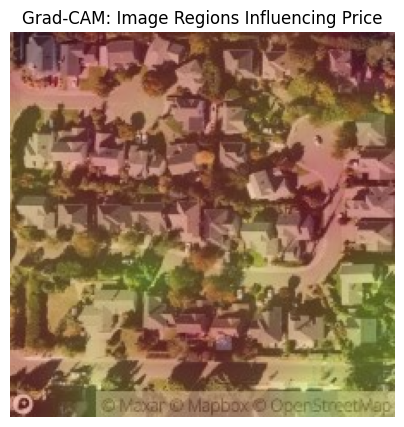

In [53]:
import matplotlib.pyplot as plt
img_np = img[0].detach().permute(1,2,0).cpu().numpy()
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = heatmap / 255.0

overlay = 0.7 * img_np + 0.3 * heatmap
overlay = np.clip(overlay, 0, 1)

plt.figure(figsize=(5,5))
plt.imshow(overlay)
plt.axis("off")
plt.title("Grad-CAM: Image Regions Influencing Price")
plt.show()

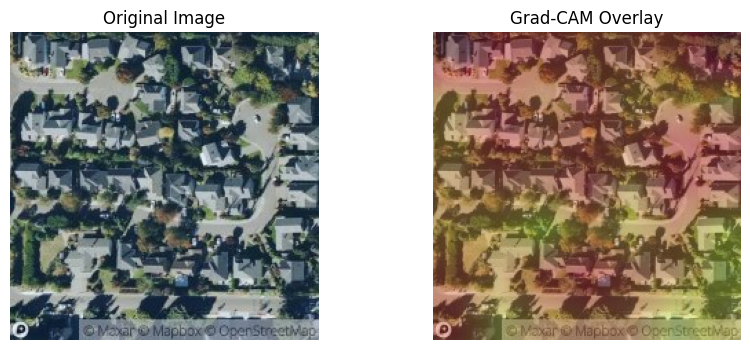

In [54]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay)
plt.title("Grad-CAM Overlay")
plt.axis("off")

plt.show()

In [55]:
import numpy as np

prices = np.array([val_dataset[i][2].item() for i in range(len(val_dataset))])

low_idx  = prices.argsort()[:2]          # lowest 2
high_idx = prices.argsort()[-2:]         # highest 2
mid_idx  = [prices.argsort()[len(prices)//2]]

sample_indices = list(low_idx) + mid_idx + list(high_idx)

In [56]:
def plot_side_by_side(idx,save=False):
    img, tab, y = val_dataset[idx]

    img = img.unsqueeze(0).to(device)
    tab = tab.unsqueeze(0).to(device)

    cam = gradcam.generate(img, tab)

    img_np = img[0].detach().permute(1,2,0).cpu().numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET) / 255.0
    overlay = np.clip(0.6 * img_np + 0.4 * heatmap, 0, 1)

    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(overlay)
    plt.title(f"Grad-CAM | Price(log): {y.item():.2f}")
    plt.axis("off")

    if save:
        plt.savefig(f"gradcam_{idx}.png", bbox_inches="tight", dpi=200)

    plt.show()

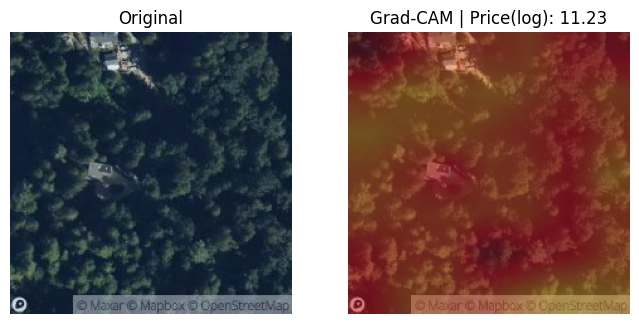

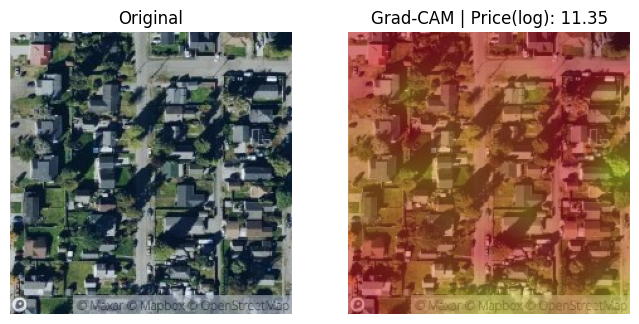

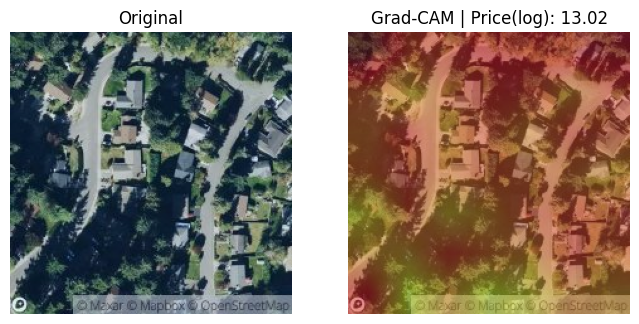

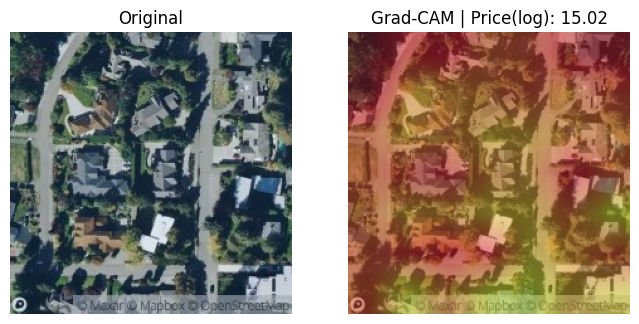

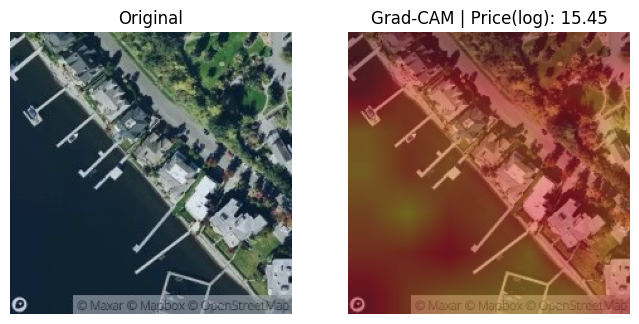

In [57]:
for idx in sample_indices:
    plot_side_by_side(idx,save=True)

In [58]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5404 entries, 0 to 5403
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              5404 non-null   int64  
 1   bedrooms        5404 non-null   int64  
 2   bathrooms       5404 non-null   float64
 3   sqft_living     5404 non-null   int64  
 4   sqft_lot        5404 non-null   int64  
 5   floors          5404 non-null   float64
 6   waterfront      5404 non-null   int64  
 7   view            5404 non-null   int64  
 8   condition       5404 non-null   int64  
 9   grade           5404 non-null   int64  
 10  sqft_above      5404 non-null   int64  
 11  sqft_basement   5404 non-null   int64  
 12  yr_built        5404 non-null   int64  
 13  yr_renovated    5404 non-null   int64  
 14  zipcode         5404 non-null   int64  
 15  lat             5404 non-null   float64
 16  long            5404 non-null   float64
 17  sqft_living15   5404 non-null   i

In [59]:
test_df["house_age"] = 2025 - test_df["yr_built"]
test_df["is_renovated"] = (test_df["yr_renovated"] > 0).astype(int)

In [60]:
X_test = test_df[TABULAR_FEATURES]

In [61]:
test_pred_log = xgb_model.predict(X_test)
test_pred_price = np.expm1(test_pred_log)

In [62]:
submission = pd.DataFrame({
    "id": test_ids.values,
    "predicted_price": test_pred_price
})

In [63]:
submission.to_csv("final_price_predictions.csv", index=False)

In [64]:
import os
os.listdir("/kaggle/working")

['final_price_predictions.csv',
 'gradcam_2221.png',
 'gradcam_2970.png',
 'gradcam_2681.png',
 'gradcam_2637.png',
 'gradcam_451.png',
 '.virtual_documents']

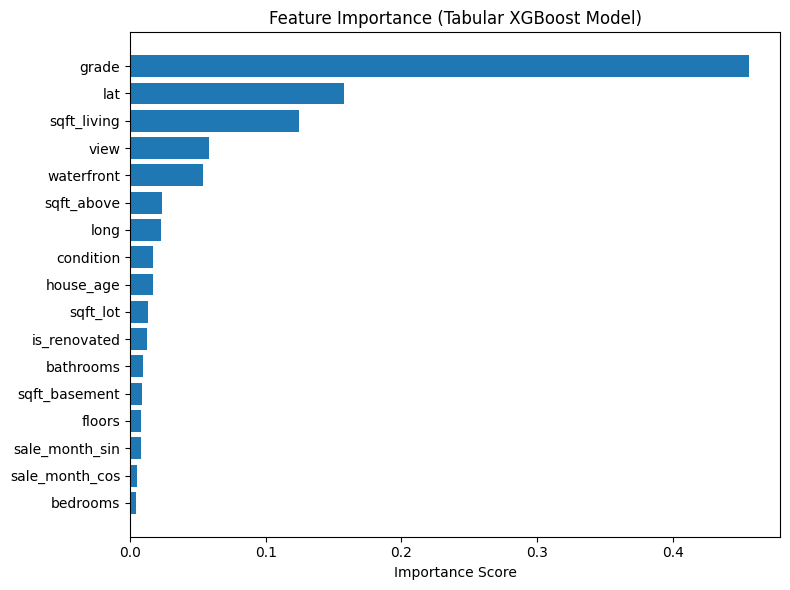

In [65]:
import numpy as np
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
feature_names = TABULAR_FEATURES

idx = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.barh(
    np.array(feature_names)[idx],
    importances[idx]
)
plt.xlabel("Importance Score")
plt.title("Feature Importance (Tabular XGBoost Model)")
plt.tight_layout()
plt.show()

In [66]:
from sklearn.model_selection import train_test_split
X = train_df[TABULAR_FEATURES].values
y = np.log1p(train_df["price"].values)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)

In [67]:
# True values (log-price)
trues = y_val

# Predictions from tabular model
preds = xgb_model.predict(X_val)

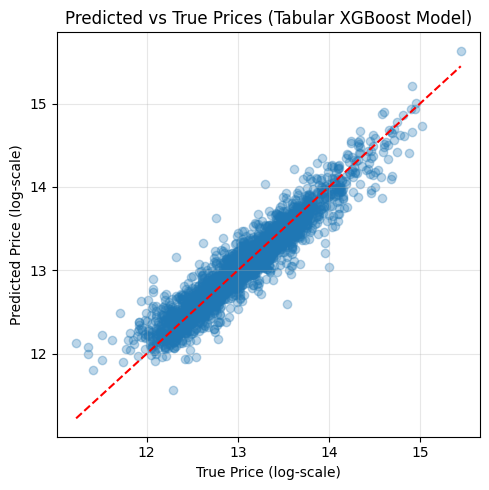

In [68]:
plt.figure(figsize=(5,5))
plt.scatter(trues, preds, alpha=0.3)
plt.plot(
    [trues.min(), trues.max()],
    [trues.min(), trues.max()],
    linestyle="--",
    color="red"
)
plt.xlabel("True Price (log-scale)")
plt.ylabel("Predicted Price (log-scale)")
plt.title("Predicted vs True Prices (Tabular XGBoost Model)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()